### Description

#### Evaluates a number of estimators to construct the Voting Regressor meta-estimator with weights such that the mean squared error of the combined predictions of the estimators is minimized.

#### version: 1.0

#### TODO:
- remove unused imports
- full db integration
- prune features
- finalize estimator selection
- estimator comp. df
- finalize 'fine tuning'
- save final estimators
- save final voting regressor
- plot results
- general file cleanup

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import joblib

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Plots as needed
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Data split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ARDRegression
from sklearn.neighbors import KNeighborsRegressor

# Model Validation and Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# MSE minimization
from sklearn.metrics import mean_squared_error
from scipy import optimize

# DB interface
from sqlalchemy import create_engine
from config import db_password

## Interface with Database and create DataFrames

In [5]:
# Construct db string
user = 'postgres'
host = 'housing-prices.ch2ctomvepex.us-east-1.rds.amazonaws.com'
name = 'housing-prices'

db_string = f'postgresql://{user}:{db_password}@{host}/{name}'

In [6]:
# Create Connection Engine

engine = create_engine(db_string)

In [7]:
# Example - load data from RDS into pandas DataFrame

sf_db = pd.read_sql_table('sanfran', engine)
sf_db.head()

,price,bedroom,sqft,neighborhood,bathroom,amenity_count,cityid
0,3985,2,920.0,cole valley / ashbury hts,1.0,5,2
1,3961,1,745.0,SOMA / south beach,1.0,9,2
2,7435,3,1146.0,SOMA / south beach,2.0,9,2
3,2785,2,1000.0,alamo square / nopa,1.5,7,2
4,7250,3,1146.0,SOMA / south beach,2.0,9,2


In [17]:
# Example Data from CSV used here

# Import Data
sf_df = pd.read_csv("../../First Segment Rubric - Sample Data/sf_clean.csv")
sf_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


## Temp Data from CSVs

In [2]:
# Create city list and general path

# TODO: Edit to match RDS table names
city_list = ['austin','boston','sf','chandler','chicago','houston','la','pittsburgh','spokane']

# Group by city population
low_list = ['chandler', 'pittsburgh', 'spokane']
mid_list = ['austin', 'boston', 'sf']
high_list = ['chicago', 'la', 'houston']

# TODO: Edit to match RDS path
general_path = '../../First Segment Rubric - Clean/csv/'

In [3]:
# Create dataframes for each pop grouping and overall


def build_dfs(cities, gen_path, lowpop_list=[], midpop_list=[], highpop_list=[]):
    
    # Dummy cityID for cities temp. missing it
    dummy_id = 10

    low_pop = pd.DataFrame()
    mid_pop = pd.DataFrame()
    high_pop = pd.DataFrame()
    all_pop = pd.DataFrame()

    # Iterate through cities to get data
    for city in cities:
        
        city_fp = f'{gen_path}{city}_clean_data.csv'
        
        
        # Determine low, mid, or high pop
        
        if city in lowpop_list:
            
            # Create temp city df
            city = pd.read_csv(city_fp)
        
            # Check for cityID
            if city.columns[-1] != 'cityID':
                city['cityID'] = dummy_id
                dummy_id = dummy_id + 1
                
            # Check for num amen
            if 'number of amenities' in city.columns:
                city['amenity_count'] = city['number of amenities']
                city = city.drop(columns='number of amenities', axis=1)
                
            # Add class col
            city['pop_class'] = 1
            
            # Add to low df
            low_pop = pd.concat([low_pop,city])
                
        elif city in midpop_list:
            
           # Create temp city df
            city = pd.read_csv(city_fp)
        
            # Check for cityID
            if city.columns[-1] != 'cityID':
                city['cityID'] = dummy_id
                dummy_id = dummy_id + 1
            
            # Check for num amen
            if 'number of amenities' in city.columns:
                city['amenity_count'] = city['number of amenities']
                city = city.drop(columns='number of amenities', axis=1)
            
            # Add class col
            city['pop_class'] = 2
            
            # Add to mid df
            mid_pop = pd.concat([mid_pop,city])
                
        elif city in highpop_list:
            
            # Create temp city df
            city = pd.read_csv(city_fp)
        
            # Check for cityID
            if city.columns[-1] != 'cityID':
                city['cityID'] = dummy_id
                dummy_id = dummy_id + 1
                
            # Check for num amen    
            if 'number of amenities' in city.columns:
                city['amenity_count'] = city['number of amenities']
                city = city.drop(columns='number of amenities', axis=1)
            
            # Add class col
            city['pop_class'] = 3
            
            # Add to high df
            high_pop = pd.concat([high_pop,city])
        
        
        # add to all_pop
        
        all_pop = pd.concat([all_pop,city])
        
        
    return low_pop, mid_pop, high_pop, all_pop

In [4]:
# Call fn to create dfs
low_pop, mid_pop, high_pop, all_pop = build_dfs(city_list, general_path, low_list,
                                               mid_list, high_list)

In [138]:
# # Drop duplicate listings if any exist

# low_pop.drop_duplicates(subset=['price','bedroom','sqft','neighborhood','bathroom','amenity_count'], inplace=True)
# mid_pop.drop_duplicates(subset=['price','bedroom','sqft','neighborhood','bathroom','amenity_count'], inplace=True)
# high_pop.drop_duplicates(subset=['price','bedroom','sqft','neighborhood','bathroom','amenity_count'], inplace=True)
# all_pop.drop_duplicates(subset=['price','bedroom','sqft','neighborhood','bathroom','amenity_count'], inplace=True)

In [5]:
# Create df for each city for summary stats
austin_df = pd.read_csv('csv/austin_clean_data.csv')
boston_df = pd.read_csv('csv/boston_clean_data.csv')
sf_df = pd.read_csv('csv/sf_clean_data.csv')
chandler_df = pd.read_csv('csv/chandler_clean_data.csv')
chicago_df = pd.read_csv('csv/chicago_clean_data.csv')
houston_df = pd.read_csv('csv/houston_clean_data.csv')
la_df = pd.read_csv('csv/la_clean_data.csv')
pittsburgh_df = pd.read_csv('csv/pittsburgh_clean_data.csv')
spokane_df = pd.read_csv('csv/spokane_clean_data.csv')

In [82]:
# Austin
austin_df.drop(columns='cityID',axis=1,inplace=True)
austin_df.describe()

,price,bedroom,sqft,bathroom,amenity_count
count,566.000000,566.000000,566.000000,566.000000,566.000000
mean,1827.901060,1.473498,876.835689,1.424028,5.977032
std,646.076034,0.831996,343.176148,0.539146,1.740055
min,820.000000,0.000000,222.000000,1.000000,0.000000
25%,1409.000000,1.000000,650.000000,1.000000,5.000000
50%,1685.500000,1.000000,811.000000,1.000000,6.000000
75%,2167.500000,2.000000,1082.750000,2.000000,7.000000
max,5878.000000,4.000000,2237.000000,3.500000,9.000000


In [83]:
# Boston

#boston_df.drop(columns='cityID',axis=1,inplace=True)

# Drop rows with price less than $50
boston_df.drop(boston_df[boston_df.price < 50].index, inplace=True)
boston_df.reset_index()
boston_df.describe()

,price,bedroom,sqft,bathroom,amenity_count
count,415.000000,415.000000,415.000000,415.000000,415.000000
mean,2860.616867,1.751807,981.098795,1.295181,5.559036
std,1066.586847,1.034940,630.115753,0.521495,1.792566
min,795.000000,0.000000,230.000000,1.000000,0.000000
25%,2200.000000,1.000000,675.000000,1.000000,5.000000
50%,2604.000000,2.000000,900.000000,1.000000,5.000000
75%,3200.000000,2.000000,1113.500000,1.500000,7.000000
max,7800.000000,8.000000,9999.000000,3.500000,11.000000


In [84]:
# San Francisco
#sf_df.drop(columns='cityID',axis=1,inplace=True)

# Drop prices > 15000
sf_df.drop(sf_df[sf_df.price > 15000].index, inplace=True)
sf_df.reset_index()
sf_df.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityID
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.0
mean,3759.980874,1.584699,904.565574,1.416667,5.786885,2.0
std,1706.611025,1.145419,525.460992,0.663549,1.850122,0.0
min,700.000000,0.000000,120.000000,1.000000,0.000000,2.0
25%,2692.500000,1.000000,555.000000,1.000000,5.000000,2.0
50%,3400.000000,1.000000,791.000000,1.000000,6.000000,2.0
75%,4500.000000,2.000000,1125.000000,2.000000,7.000000,2.0
max,15000.000000,5.000000,4400.000000,5.500000,11.000000,2.0


In [85]:
# Chandler
#chandler_df.drop(columns='cityID',axis=1,inplace=True)
chandler_df.describe()

,price,bedroom,sqft,bathroom,amenity_count
count,703.000000,703.000000,703.000000,703.000000,703.000000
mean,1420.139403,1.691323,867.900427,1.512802,5.395448
std,617.275036,0.805976,363.848981,0.526891,1.746003
min,225.000000,0.000000,380.000000,1.000000,2.000000
25%,1320.000000,1.000000,660.000000,1.000000,3.000000
50%,1560.000000,2.000000,900.000000,1.500000,5.000000
75%,1760.500000,2.000000,1084.500000,2.000000,7.000000
max,3095.000000,8.000000,4200.000000,4.500000,9.000000


In [86]:
# Chicago
#chicago_df.drop(columns='cityID',axis=1,inplace=True)
chicago_df.describe()

,price,bedroom,sqft,bathroom,amenity_count
count,363.000000,363.000000,363.000000,363.000000,363.000000
mean,1777.818182,1.647383,936.796143,1.308540,5.311295
std,693.313343,0.914682,403.502801,0.531971,1.493840
min,325.000000,0.000000,112.000000,1.000000,0.000000
25%,1300.000000,1.000000,700.000000,1.000000,5.000000
50%,1620.000000,2.000000,864.000000,1.000000,5.000000
75%,2097.500000,2.000000,1158.000000,2.000000,6.000000
max,5000.000000,5.000000,3000.000000,4.000000,11.000000


In [87]:
# Austin
#austin_df.drop(columns='cityID',axis=1,inplace=True)
houston_df.describe()

,price,bedroom,sqft,bathroom,amenity_count
count,409.000000,409.000000,409.000000,409.000000,409.000000
mean,1314.254279,1.811736,1049.779951,1.520782,5.205379
std,466.144695,1.029591,504.741892,0.613519,1.994323
min,349.000000,0.000000,228.000000,1.000000,2.000000
25%,925.000000,1.000000,700.000000,1.000000,3.000000
50%,1167.000000,2.000000,919.000000,1.000000,5.000000
75%,1650.000000,2.000000,1293.000000,2.000000,7.000000
max,3245.000000,4.000000,2976.000000,3.500000,10.000000


In [88]:
# LA
#la_df.drop(columns='cityID',axis=1,inplace=True)

# Provisionally drop entries over $10000 (2 total)
la_df.drop(la_df[la_df.price > 10000].index, inplace=True)
la_df.reset_index()
la_df.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityID
count,681.000000,681.000000,681.000000,681.000000,681.000000,681.0
mean,2622.718062,1.353891,845.444934,1.403818,5.503671,3.0
std,958.446737,0.943797,401.772880,0.617097,1.905194,0.0
min,950.000000,0.000000,100.000000,1.000000,0.000000,3.0
25%,1975.000000,1.000000,625.000000,1.000000,4.000000,3.0
50%,2430.000000,1.000000,755.000000,1.000000,6.000000,3.0
75%,2949.000000,2.000000,996.000000,2.000000,7.000000,3.0
max,8500.000000,5.000000,3497.000000,5.000000,10.000000,3.0


In [89]:
# Pittsburgh
#pittsburgh_df.drop(columns='cityID',axis=1,inplace=True)
pittsburgh_df.describe()

,price,bedroom,sqft,bathroom,number of amenities
count,633.000000,633.000000,633.000000,633.000000,633.000000
mean,1380.406003,1.605055,818.097946,1.227488,5.056872
std,503.644978,0.818365,288.667289,0.404175,1.223422
min,625.000000,0.000000,300.000000,1.000000,3.000000
25%,950.000000,1.000000,570.000000,1.000000,5.000000
50%,1275.000000,1.000000,800.000000,1.000000,5.000000
75%,1650.000000,2.000000,975.000000,1.500000,6.000000
max,2785.000000,4.000000,1650.000000,2.000000,9.000000


In [90]:
# Spokane
#spokane_df.drop(columns='cityID',axis=1,inplace=True)
spokane_df.describe()

,price,bedroom,sqft,bathroom,amenity_count
count,566.000000,566.000000,566.000000,566.000000,566.000000
mean,1507.521201,1.835689,985.086572,1.462014,6.590106
std,397.020017,0.947955,361.153964,0.523659,1.847699
min,725.000000,0.000000,227.000000,1.000000,0.000000
25%,1275.000000,1.000000,727.000000,1.000000,6.000000
50%,1466.000000,2.000000,952.000000,1.000000,7.000000
75%,1677.000000,2.000000,1141.000000,2.000000,8.000000
max,4600.000000,6.000000,2914.000000,3.000000,11.000000


In [91]:
# Low Pop
low_pop.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityID,pop_class
count,1902.000000,1902.000000,1902.000000,1902.000000,1902.000000,1902.000000,1902.0
mean,1432.919033,1.705573,886.198212,1.402734,5.638275,13.188749,1.0
std,523.946564,0.859125,346.318187,0.504063,1.744177,1.722647,0.0
min,225.000000,0.000000,227.000000,1.000000,0.000000,11.000000,1.0
25%,1180.000000,1.000000,657.500000,1.000000,5.000000,11.000000,1.0
50%,1466.000000,2.000000,874.000000,1.000000,6.000000,14.000000,1.0
75%,1710.000000,2.000000,1054.000000,2.000000,7.000000,15.000000,1.0
max,4600.000000,8.000000,4200.000000,4.500000,11.000000,15.000000,1.0


In [92]:
# Mid Pop
mid_pop.drop(mid_pop[mid_pop.price > 15000].index,inplace=True)
mid_pop.reset_index()
mid_pop.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityID,pop_class
count,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.0
mean,2668.172977,1.590943,916.717892,1.382331,5.795843,4.051225,2.0
std,1398.839593,0.995387,498.493376,0.573109,1.795416,3.998650,0.0
min,1.000000,0.000000,120.000000,1.000000,0.000000,1.000000,2.0
25%,1700.000000,1.000000,639.500000,1.000000,5.000000,1.000000,2.0
50%,2349.000000,1.000000,840.000000,1.000000,6.000000,2.000000,2.0
75%,3200.000000,2.000000,1100.000000,2.000000,7.000000,10.000000,2.0
max,15000.000000,8.000000,9999.000000,5.500000,11.000000,10.000000,2.0


In [93]:
# High Pop
high_pop.drop(high_pop[high_pop.price > 10000].index, inplace=True)
high_pop.reset_index()
high_pop.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityID,pop_class
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.0
mean,2044.761215,1.556936,925.553485,1.413389,5.371981,8.051070,3.0
std,967.968083,0.982426,442.248591,0.600920,1.843778,4.771883,0.0
min,325.000000,0.000000,100.000000,1.000000,0.000000,3.000000,3.0
25%,1357.000000,1.000000,650.000000,1.000000,4.000000,3.000000,3.0
50%,1895.000000,1.000000,819.000000,1.000000,5.000000,12.000000,3.0
75%,2518.000000,2.000000,1064.000000,2.000000,7.000000,13.000000,3.0
max,8500.000000,5.000000,3497.000000,5.000000,11.000000,13.000000,3.0


## Examine data

In [6]:
all_pop.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityID,pop_class
count,4848.000000,4848.000000,4848.000000,4848.000000,4848.000000,4848.000000,4848.000000
mean,1992.465140,1.668317,937.918936,1.459571,5.587871,4.956271,1.954620
std,1188.873793,0.960823,499.195650,0.638668,1.863872,2.668800,0.834081
min,225.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,1350.000000,1.000000,665.000000,1.000000,4.000000,3.000000,1.000000
50%,1700.000000,2.000000,869.000000,1.000000,6.000000,5.000000,2.000000
75%,2370.000000,2.000000,1118.250000,2.000000,7.000000,7.000000,3.000000
max,27000.000000,8.000000,15492.000000,5.500000,11.000000,9.000000,3.000000


In [7]:
# Check dtypes
all_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4848 entries, 0 to 678
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4848 non-null   int64  
 1   bedroom        4848 non-null   int64  
 2   sqft           4848 non-null   float64
 3   bathroom       4848 non-null   float64
 4   amenity_count  4848 non-null   int64  
 5   cityID         4848 non-null   int64  
 6   pop_class      4848 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 303.0 KB


In [8]:
# Check num unique values
all_pop.nunique().sort_values()

pop_class           3
bedroom             9
cityID              9
bathroom           11
amenity_count      11
sqft              987
price            1284
dtype: int64

### Treat Appropriate Features as Categorical

In [9]:
# Treat features with fewer than 15 unique values as cat

num_unq = all_pop.drop(columns='price').nunique().sort_values()

num_ft, cat_ft = [], []

for i in range(all_pop.drop(columns='price').shape[1]):
    
    if num_unq.values[i] < 15:
        cat_ft.append(num_unq.index[i])
    else:
        num_ft.append(num_unq.index[i])

print(num_ft)
print(cat_ft)

['sqft']
['pop_class', 'bedroom', 'cityID', 'bathroom', 'amenity_count']


In [144]:
all_t = all_pop.copy()

for ft in cat_ft:
    if ft != 'pop_class':
        if ft != 'cityID':
            all_t = pd.concat([all_t,pd.DataFrame(pd.get_dummies(all_t[ft],
                                                                       prefix=ft))],axis=1)
            all_t.drop(columns=ft,axis=1,inplace=True)
all_t.head()

,price,sqft,cityID,pop_class,bedroom_0,bedroom_1,bedroom_2,bedroom_3,bedroom_4,bedroom_5,...,amenity_count_2,amenity_count_3,amenity_count_4,amenity_count_5,amenity_count_6,amenity_count_7,amenity_count_8,amenity_count_9,amenity_count_10,amenity_count_11
0,1191,600.0,1,2,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1425,526.0,1,2,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1266,578.0,1,2,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1144,351.0,1,2,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1775,1236.0,1,2,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


<AxesSubplot:>

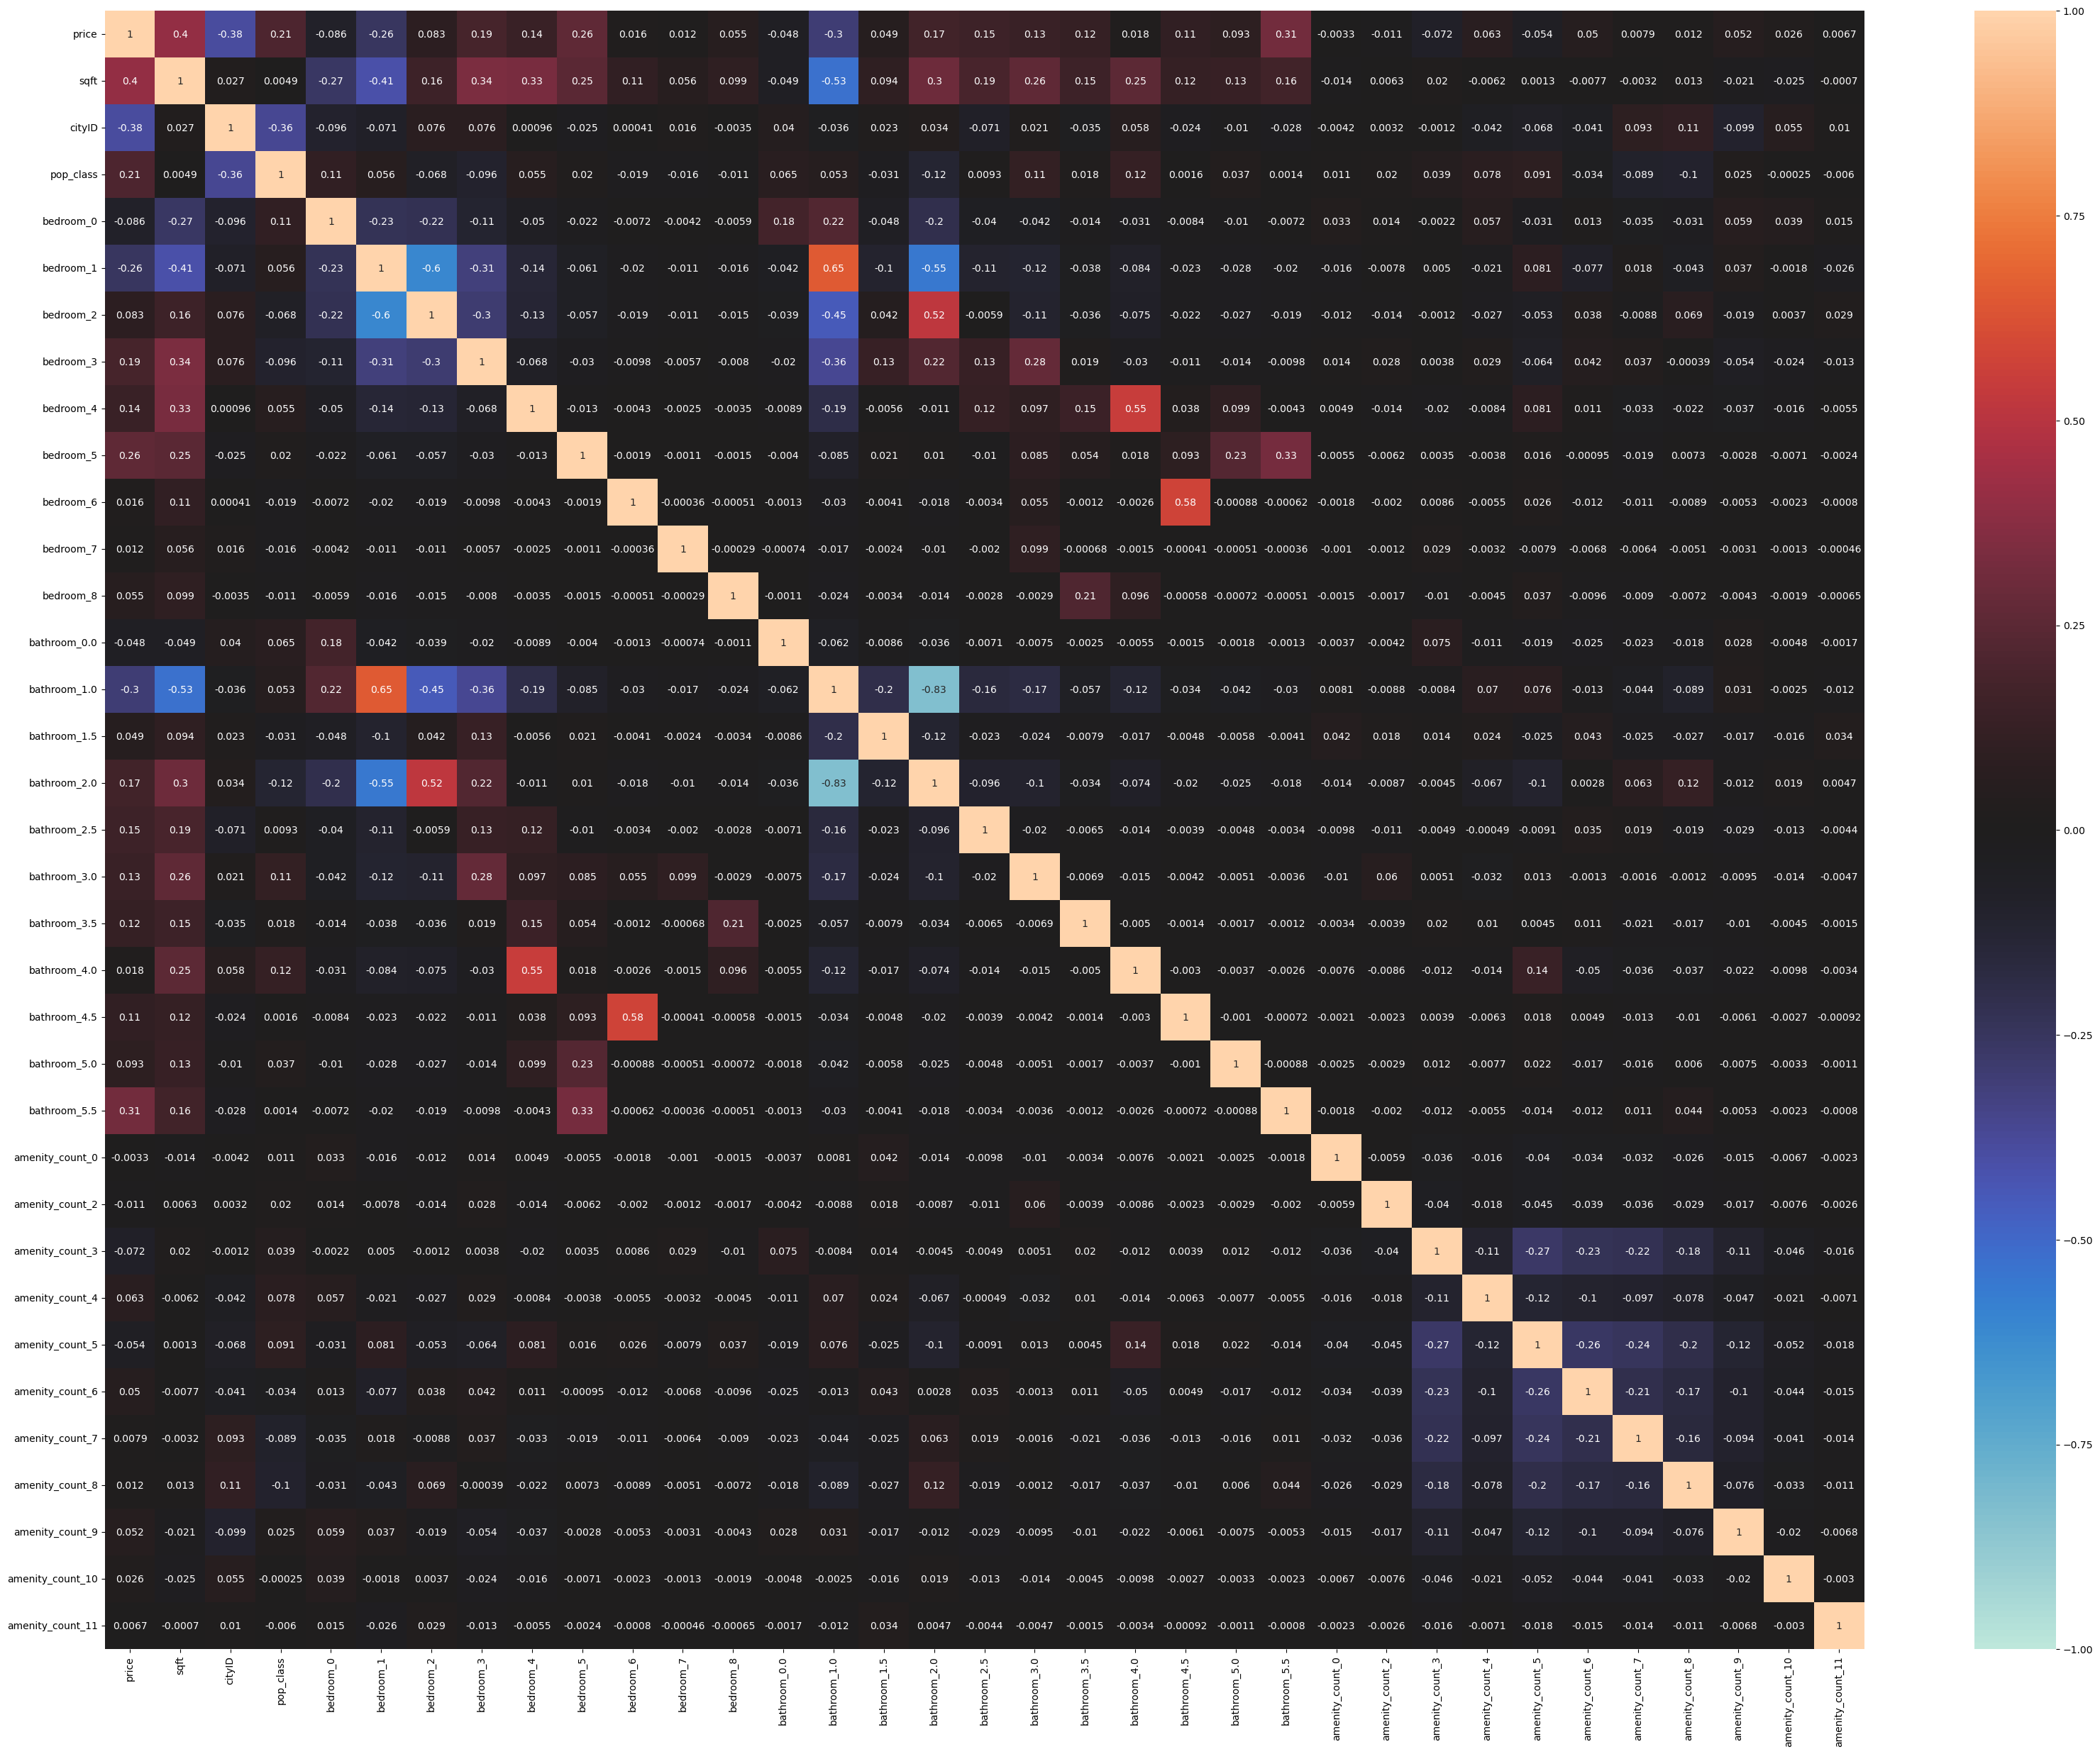

In [146]:
# Examine Corr Values
plt.figure(figsize=[40,30])
sns.heatmap(all_t.corr(),annot=True,vmin=-1,vmax=1,center=0)

In [147]:
# Corr wrt 'price'
all_t.corr().price.sort_values(ascending=False)

price               1.000000
sqft                0.401150
bathroom_5.5        0.314146
bedroom_5           0.260541
pop_class           0.210094
bedroom_3           0.185272
bathroom_2.0        0.169520
bathroom_2.5        0.153840
bedroom_4           0.139323
bathroom_3.0        0.134623
bathroom_3.5        0.121482
bathroom_4.5        0.107270
bathroom_5.0        0.092910
bedroom_2           0.083138
amenity_count_4     0.062742
bedroom_8           0.054816
amenity_count_9     0.052167
amenity_count_6     0.050400
bathroom_1.5        0.049052
amenity_count_10    0.025967
bathroom_4.0        0.017679
bedroom_6           0.016380
bedroom_7           0.012174
amenity_count_8     0.012168
amenity_count_7     0.007862
amenity_count_11    0.006739
amenity_count_0    -0.003318
amenity_count_2    -0.010785
bathroom_0.0       -0.048200
amenity_count_5    -0.053937
amenity_count_3    -0.072443
bedroom_0          -0.085892
bedroom_1          -0.255684
bathroom_1.0       -0.297626
cityID        

<AxesSubplot:>

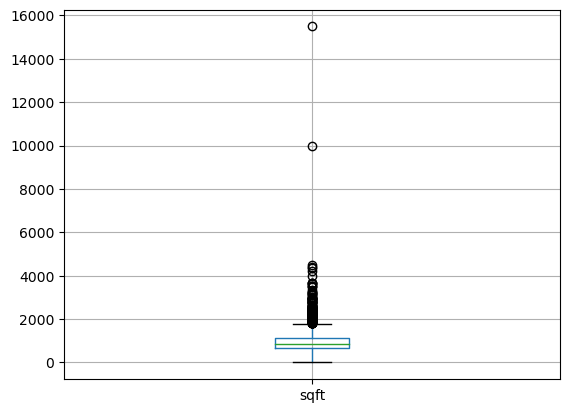

In [133]:
# Dist of num ft 'sqft' -> appears many outside 1.5*IQR
all_pop.boxplot(column='sqft')

In [135]:
# Calc iqr of sqft and upper/lower bounds
sqft_iqr = all_t.sqft.quantile(.75)-all_t.sqft.quantile(.25)
upper = 1.5*sqft_iqr + all_t.sqft.quantile(.75)
lower =  all_t.sqft.quantile(.25) - 1.5*sqft_iqr
print(lower)
print(upper)

-14.875
1798.125


In [136]:
all_t.drop(all_t[all_t.sqft > upper].index, inplace=True)
all_t.reset_index()

# Drop pop_class b/c stratification is by city
all_t.drop(columns='pop_class',inplace=True)

In [137]:
# Before examination, split so that the test set remains unobserved

# Split using SSS to incorporate data from each of the 3 groups in test and train sets.
split = StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_t, all_t['cityID']):
    strat_train_set = all_t.iloc[train_index]
    strat_test_set = all_t.iloc[test_index]

In [138]:
# Create a new df that is a copy of the training set to preserve it.
all_train = strat_train_set.copy()

# Repeat for test set
all_test = strat_test_set.copy()

# Show first 5 rows of training set
all_train.head()

,price,sqft,cityID,bedroom_0,bedroom_1,bedroom_2,bedroom_3,bedroom_4,bedroom_5,bedroom_6,...,amenity_count_2,amenity_count_3,amenity_count_4,amenity_count_5,amenity_count_6,amenity_count_7,amenity_count_8,amenity_count_9,amenity_count_10,amenity_count_11
182,2995,1150.0,6,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
132,1605,983.0,5,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
194,1195,1100.0,9,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
338,1771,1121.0,5,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
216,1799,1076.0,5,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [139]:
# Compare Train Test Split
train_set,test_set = train_test_split(all_t, test_size=0.2, random_state=42)

In [141]:
# df for comparison of test sets
split_comp = pd.DataFrame()
split_comp['Overall'] = all_t.cityID.value_counts() / len(all_t.cityID)
split_comp['Strat_City'] = all_test.cityID.value_counts() / len(all_test.cityID)
split_comp['Random'] = test_set.cityID.value_counts() / len(test_set.cityID)
split_comp['Random %Error'] = ((split_comp.Random - split_comp.Overall) / split_comp.Overall)*100
split_comp['Strat_City %Error'] = ((split_comp.Strat_City - split_comp.Overall) / split_comp.Overall)*100
split_comp

,Overall,Strat_City,Random,Random %Error,Strat_City %Error
5,0.149081,0.148515,0.137199,-7.969639,-0.379507
1,0.143706,0.144272,0.185290,28.937008,0.393701
3,0.143423,0.142857,0.141443,-1.380671,-0.394477
9,0.142291,0.142857,0.128713,-9.542744,0.397614
7,0.106931,0.107496,0.091938,-14.021164,0.529101
8,0.085149,0.084866,0.084866,-0.332226,-0.332226
4,0.084017,0.083451,0.076379,-9.090909,-0.673401
2,0.072984,0.073550,0.076379,4.651163,0.775194
6,0.072419,0.072136,0.077793,7.421875,-0.390625


#### Stratified Shuffle Split demonstrates better representation of the population groupings

In [142]:
# Drop columns not used in analysis
all_train.drop(columns=['cityID'],axis=1,inplace=True)
all_test.drop(columns=['cityID'],axis=1,inplace=True)

In [10]:
# Create a df of corr between features
corr_matrix = all_train.corr()

# Display each feature's corr with target
corr_matrix.price.sort_values(ascending=False)

price            1.000000
sqft             0.471596
bathroom         0.409583
bedroom          0.377352
amenity_count    0.095283
Name: price, dtype: float64

<AxesSubplot:>

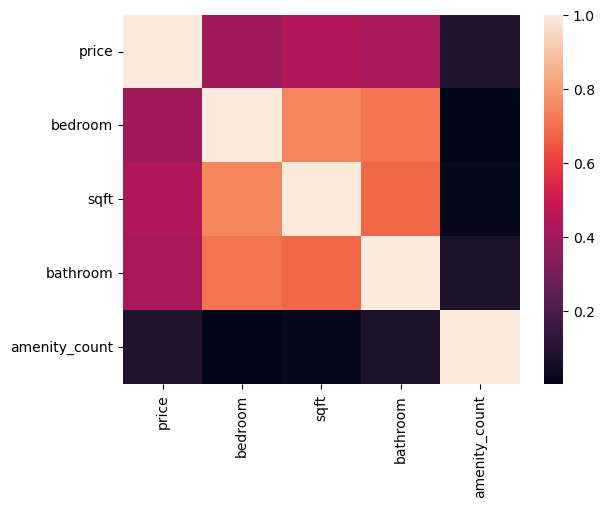

In [102]:
# Plot corr
sns.heatmap(corr_matrix)

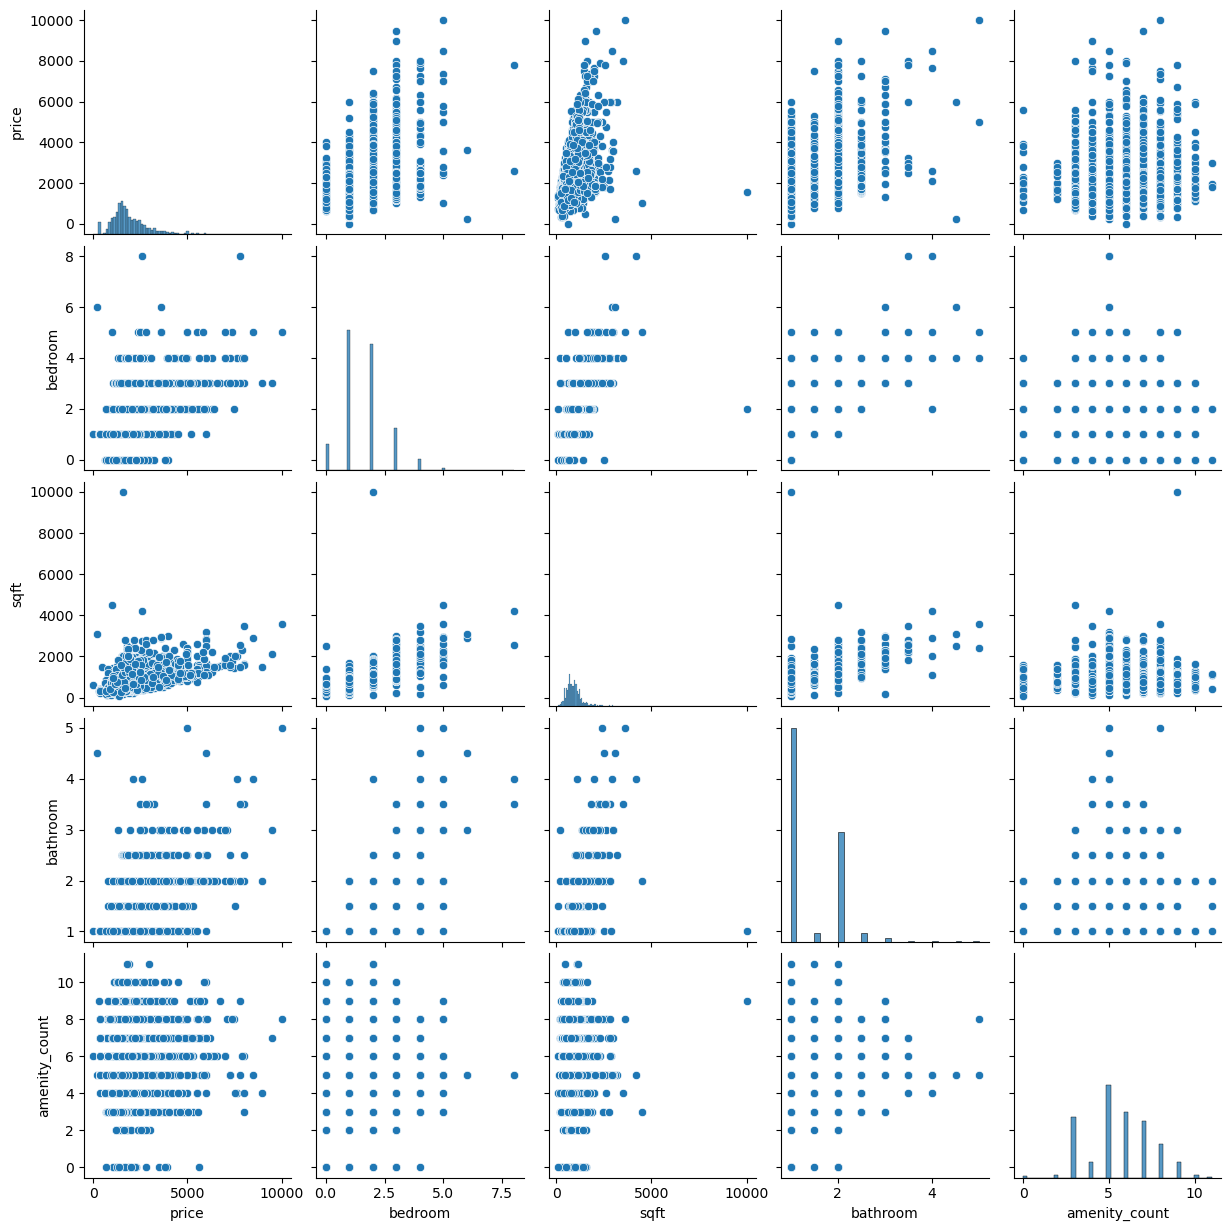

In [103]:
# Examine the dist. of each variable
sns.pairplot(all_train)

### Evaluate Features and Elimate as Appropriate

In [183]:
# # Drop features with corr near zero from train and test dfs

# all_train.drop(columns=['amenity_count'],axis=1,inplace=True)
# all_test.drop(columns=['amenity_count'],axis=1,inplace=True)


### Preprocess Finalized Feature Set

In [93]:
# Remove target

X_train = all_train.drop(columns='price').values
y_train = all_train.price.values

X_test = all_test.drop(columns='price').values
y_test = all_test.price.values

In [94]:
# Scale using RobustScaler due to spread

rs = RobustScaler()

robust = rs.fit(X_train)

X_train_scaled = robust.transform(X_train)

X_test_scaled = robust.transform(X_test)

## Estimator Construction

In [95]:
# Create fn to out scores from cross_val_score to select estimators

def score_info(scores):
    MSE = -scores
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    return MSE.mean(), MSE.std()

In [47]:
# Estimator Comp. Data
est_comp = pd.DataFrame()

In [96]:
# Gradient Boosting Regressor

gbr_cvs = cross_val_score(GradientBoostingRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

gbr_mean,gbr_std = score_info(gbr_cvs)
est_comp['gbr'] = [gbr_mean,gbr_std]

Mean: 203376.18614213032
STD: 42743.44483351893


In [97]:
# Random Forest Regressor

rfr_cvs = cross_val_score(RandomForestRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

rfr_mean,rfr_std=score_info(rfr_cvs)
est_comp['rfr'] = [rfr_mean,rfr_std]

Mean: 184290.3547223841
STD: 28803.86406652527


In [98]:
# Lasso

lasso_cvs = cross_val_score(LassoCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

lasso_mean,lasso_std=score_info(lasso_cvs)
est_comp['lasso'] = [lasso_mean,lasso_std]

Mean: 536946.2457232329
STD: 88503.30332271615


In [99]:
# Ridge

ridge_cvs = cross_val_score(RidgeCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ridge_mean,ridge_std=score_info(ridge_cvs)
est_comp['ridge'] = [ridge_mean,ridge_std]

Mean: 536710.6734551302
STD: 89918.10812301812


In [100]:
# Adaboost

ada_cvs = cross_val_score(AdaBoostRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ada_mean,ada_std=score_info(ada_cvs)
est_comp['ada'] = [ada_mean,ada_std]

Mean: 421148.1313549907
STD: 54175.98731260214


In [101]:
#ARDRegression

ard_cvs = cross_val_score(ARDRegression(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ard_mean,ard_std=score_info(ard_cvs)
est_comp['ard'] = [ard_mean,ard_std]

Mean: 537246.3787125775
STD: 91217.82294756184


In [102]:
# SVM with polynomial kernel

svp_cvs = cross_val_score(SVR(kernel='poly'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svp_mean,svp_std = score_info(svp_cvs)
est_comp['svp'] = [svp_mean,svp_std]

Mean: 859514.8188825592
STD: 134021.2638475721


In [103]:
# K nearest regression

knn_cvs = cross_val_score(KNeighborsRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

knn_mean,knn_std = score_info(knn_cvs)
est_comp['knn'] = [knn_mean,knn_std]

Mean: 333574.86323269166
STD: 72230.17586645839


In [104]:
# ExtraTrees regression
from sklearn.ensemble import ExtraTreesRegressor

et_cvs = cross_val_score(ExtraTreesRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

et_mean,et_std = score_info(et_cvs)

Mean: 211603.87150126678
STD: 35098.96442332173


In [105]:
svl_cvs = cross_val_score(SVR(kernel='linear'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svl_mean,svl_std = score_info(svl_cvs)

Mean: 686328.1665795629
STD: 111669.72855930548


In [106]:
svr_cvs = cross_val_score(SVR(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svr_mean,svr_std = score_info(svr_cvs)

Mean: 891649.3093143287
STD: 140476.2972907964


In [107]:
svs_cvs = cross_val_score(SVR(kernel='sigmoid'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svs_mean,svs_std = score_info(svs_cvs)

Mean: 827675.8244010959
STD: 131753.42264602604


In [108]:
from sklearn.ensemble import BaggingRegressor

bag_cvs = cross_val_score(BaggingRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

bag_mean,bag_std = score_info(bag_cvs)


Mean: 192404.38051985903
STD: 35588.72443736508


In [109]:
from sklearn.linear_model import TweedieRegressor

tr_cvs = cross_val_score(TweedieRegressor(power=2,link='log'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

tr_mean,tr_std = score_info(tr_cvs)

Mean: 713718.469584855
STD: 115634.4441660366


In [110]:
from sklearn.linear_model import TheilSenRegressor

tsr_cvs = cross_val_score(TheilSenRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

tsr_mean,tsr_std = score_info(tsr_cvs)

Mean: 554966.5168161648
STD: 92064.91329710413


In [63]:
from sklearn.linear_model import HuberRegressor, LinearRegression

hbr_cvs = cross_val_score(HuberRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

hbr_mean,hbr_std = score_info(hbr_cvs)

Mean: 1121188.5190361822
STD: 429667.38235421036


In [64]:
ls_cvs = cross_val_score(LinearRegression(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ls_mean,ls_std = score_info(ls_cvs)

Mean: 1041534.5123797614
STD: 339806.83822481526


In [207]:
# To-Do: Plots

## Estimator Tuning

In [65]:
def mod_imp(model):
    scores = cross_val_score(model,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)
    
    MSE = -scores
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}') 

In [314]:
def plot_lc(model,X_d,y_d):
    
    X, X_val, y, y_val = train_test_split(X_d,y_d, test_size=0.2, random_state=42)
    train_err = []
    val_err = []
    
    for k in range(1,len(X)):
        model.fit(X[:k],y[:k])
        y_pred = model.predict(X[:k])
        y_val_pred = model.predict(X_val)
        train_err.append(mean_squared_error(y[:k],y_pred[:k]))
        val_err.append(mean_squared_error(y_val,y_val_pred))
    
    plt.plot(train_err,'r-',label='train')
    plt.plot(val_err,'b-',label='validation')

In [ ]:
def plot_expect(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    
    plt.plot(X_train,y_train)
    plt.plot(X_test,y_test)

In [111]:
# GBR

model = GradientBoostingRegressor()


mod_params = {
    'learning_rate': np.arange(.5,.6,.05),
    'n_estimators': np.arange(7,13),
    'subsample': np.arange(.93,.97,0.005),
    'max_depth': [6,7,8],
    'random_state': [42],
    'max_features': ['sqrt'],
    'alpha': [1e-30,1e-20]
}


    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
gbr = model_cv.best_estimator_

mod_imp(gbr)

Fitting 15 folds for each of 576 candidates, totalling 8640 fits
Mean: 211603.47008663282
STD: 50431.40097446247


C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: invalid value encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: invalid value encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: invalid value encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ense

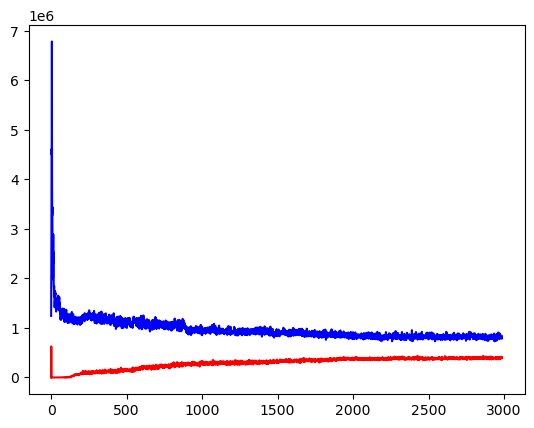

In [325]:
plot_lc(gbr,X_train_scaled,y_train)

In [112]:
# RFR

model = RandomForestRegressor()


mod_params = {
    'n_estimators': np.arange(20,40),
    'random_state': [42],
    'max_features': ['sqrt','log2']
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
rfr = model_cv.best_estimator_

mod_imp(rfr)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
Mean: 206886.09895005455
STD: 40508.74146739888


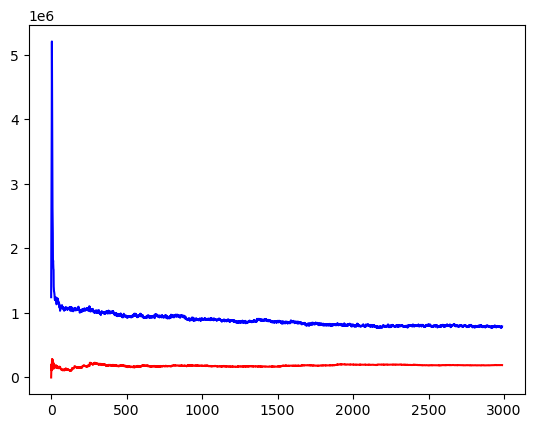

In [324]:
plot_lc(rfr,X_train_scaled,y_train)

In [113]:
# ADA

model = AdaBoostRegressor()


mod_params = {
    'learning_rate': np.arange(.1,.14,.01),
    'n_estimators': np.arange(1,15),
    'random_state': [42]
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ada = model_cv.best_estimator_

mod_imp(ada)

Fitting 15 folds for each of 70 candidates, totalling 1050 fits
Mean: 327759.20803050074
STD: 66979.48225631817


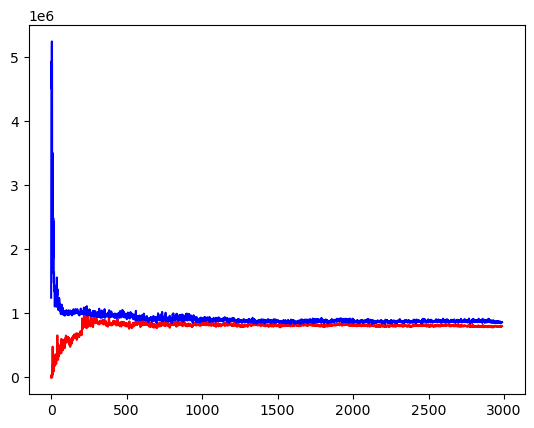

In [321]:
plot_lc(ada,X_train_scaled,y_train)

In [114]:
# ARD

model = ARDRegression(n_iter=1000)


mod_params = {
    'alpha_1': [1e6,1e7,1e8,1e9,1e10,1e11,1e12],
    'alpha_2': [1e-30,1e-25,1e-20,1e-15],
    'lambda_1': [1e-35,1e-32,1e-30,1e-28],
    'lambda_2': [1e3,1e4,1e5,1e6]
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ard = model_cv.best_estimator_

mod_imp(ard)

Fitting 15 folds for each of 448 candidates, totalling 6720 fits
Mean: 536347.9233470439
STD: 90786.71809091064


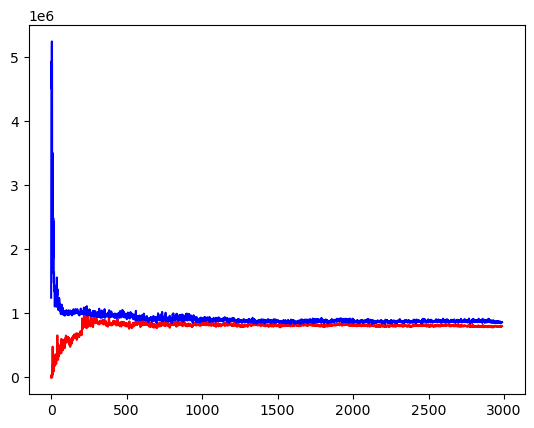

In [332]:
plot_lc(ada,X_train_scaled,y_train)

In [115]:
lasso = LassoCV(max_iter=5000, cv=15,n_jobs=-1,
               random_state=42)
mod_imp(lasso)

Mean: 536590.5521700846
STD: 90149.71650413961


In [116]:
ridge = RidgeCV()
mod_imp(ridge)

Mean: 536710.6734551302
STD: 89918.10812301812


In [117]:
# Poly SVM

model = SVR(kernel='poly')


mod_params = {
    'C': np.arange(.4,.5,.01),
    'epsilon': np.arange(0.3,.4,0.01)
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
svp = model_cv.best_estimator_

mod_imp(svp)

Fitting 15 folds for each of 110 candidates, totalling 1650 fits
Mean: 902290.5111781439
STD: 138908.3914706791


In [41]:
svp.get_params()

{'C': 0.4900000000000001,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.4000000000000001,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

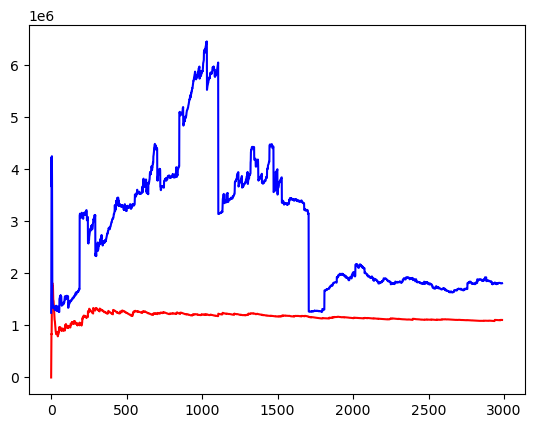

In [340]:
plot_lc(svp,X_train_scaled,y_train)

In [118]:
# KNN

model = KNeighborsRegressor(n_jobs=-1)


mod_params = {
    'n_neighbors': np.arange(30,40,1),
    'weights': ['distance'],
    'p': [1,2]
    
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
knn = model_cv.best_estimator_

mod_imp(knn)

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Mean: 288989.3004259317
STD: 74515.2402376014


In [119]:
# Fit Estimators
gbr.fit(X_train_scaled,y_train)
rfr.fit(X_train_scaled,y_train)
ada.fit(X_train_scaled,y_train)
ard.fit(X_train_scaled,y_train)
lasso.fit(X_train_scaled,y_train)
ridge.fit(X_train_scaled,y_train)
svp.fit(X_train_scaled,y_train)
knn.fit(X_train_scaled,y_train)

KNeighborsRegressor(n_jobs=-1, n_neighbors=30, p=1, weights='distance')

## Weighted VotingRegressor

### Minimize MSE of models

In [120]:
# Specify number of estimators
n_est = 8

# Create a 'weights' array with default values of 1/n_est
w = (1/n_est)*np.ones(n_est)

In [121]:
# Create vector of predicted values from each estimator
gbr_pred = gbr.predict(X_test_scaled)
rfr_pred = rfr.predict(X_test_scaled)
ada_pred = ada.predict(X_test_scaled)
ard_pred = ard.predict(X_test_scaled)
lasso_pred = lasso.predict(X_test_scaled)
ridge_pred = ridge.predict(X_test_scaled)
svp_pred = svp.predict(X_test_scaled)
knn_pred = knn.predict(X_test_scaled)

In [122]:
# Combine prediction vectors into prediction matrix
mod_pred = np.column_stack((gbr_pred,rfr_pred,ada_pred,ard_pred,lasso_pred,ridge_pred,
                            svp_pred,knn_pred))
#mod_pred = np.column_stack((gbr_pred,rfr_pred,lasso_pred,knn_pred))

In [123]:
# Define Objective Function
def obj_fun(weights=w,y_true=y_test,y_hat=mod_pred, n_estimators=n_est):
    return (1/n_est)*np.sum((y_true - (weights@(y_hat.T)))**2)

In [124]:
# Define constraint(s)
def constraints(weights=w):
    return (1- np.sum(np.abs(weights)))

In [125]:
res = optimize.minimize(obj_fun, (1/n_est)*np.ones(n_est), method='SLSQP',
                  constraints={'fun': constraints,
                              'type': 'eq'}, options={'maxiter': 1000})
res

     fun: 20172668.77988167
     jac: array([-4194109.  , -4193730.5 , -4194745.  ,   158165.  ,    49150.25,
          75071.5 ,  2168829.75, -3738568.  ])
 message: 'Optimization terminated successfully'
    nfev: 1027
     nit: 85
    njev: 85
  status: 0
 success: True
       x: array([ 2.62908400e-01,  5.20733207e-01,  2.16334297e-01,  2.00686355e-07,
        2.26767753e-08, -9.52041060e-10,  2.38257355e-08,  2.44065840e-05])

In [126]:
optimal_mod_weights = res.x

In [127]:
# Scale weights

# First argsort returns array with first value is the index of the smallest value
# in the array provided
scaled_weights = np.argsort(optimal_mod_weights)

# Second sort returns array firs value the index of the smallest value of input
# Such that the largest value in optimal_mod_weights will have the largest index
# The resulting array has sorted and scaled from len(array) to 0

scaled_weights = np.argsort(scaled_weights)

# Add 1 to prevent zero weights
scaled_weights = scaled_weights + 1
scaled_weights

array([7, 8, 6, 4, 2, 1, 3, 5], dtype=int64)

### Create VotingRegressor with new weights

In [128]:
estimators = [('gbr',gbr),('rfr',rfr),('ada',ada),('ard',ard),('lasso',lasso),('ridge',ridge),
            ('svp',svp),('knn',knn)]

#estimators = [('gbr',gbr),('rfr',rfr),('lasso',lasso),('knn',knn)]

vrg = VotingRegressor(estimators,
                     weights=scaled_weights,
                     n_jobs=-1)

vrg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=1e-30,
                                                       learning_rate=0.55,
                                                       max_depth=7,
                                                       max_features='sqrt',
                                                       n_estimators=12,
                                                       random_state=42,
                                                       subsample=0.9650000000000001)),
                            ('rfr',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=32,
                                                   random_state=42)),
                            ('ada',
                             AdaBoostRegressor(learning_rate=0.13,
                                               n_estimators=14,
                                               random_state=42)),
                            ('...
                                           alpha_2=1e-30, lambda_1=1e-35,
                                           lambda_2=1000.0, n_iter=1000)),
                            ('lasso',
                             LassoCV(cv=15, max_iter=5000, n_jobs=-1,
                                     random_state=42)),
                            ('ridge', RidgeCV()),
                            ('svp',
                             SVR(C=0.4900000000000001,
                                 epsilon=0.4000000000000001, kernel='poly')),
                            ('knn',
                             KNeighborsRegressor(n_jobs=-1, n_neighbors=30, p=1,
                                                 weights='distance'))],
                n_jobs=-1,
                weights=array([7, 8, 6, 4, 2, 1, 3, 5], dtype=int64))

In [129]:
# Compute cv score for comparison
vrg_cvs = cross_val_score(vrg,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_mean,vrg_std = score_info(vrg_cvs)

Mean: 244199.8159943616
STD: 60185.569395113525


In [130]:
# Display Score on train vs. test
print(f'Training Score: {vrg.score(X_train_scaled, y_train)}')
print(f'Testing Score: {vrg.score(X_test_scaled, y_test)}')

Training Score: 0.8563104425068258
Testing Score: 0.7033499591353478


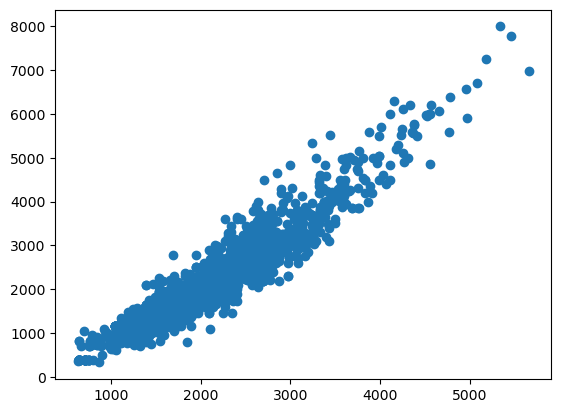

In [131]:
plt.scatter(vrg.predict(X_train_scaled),y_train)
#plt.plot(X_train,vrg.predict(X_train))